# Environment setup

In [ ]:
import os
import numpy as np
import pandas as pd
import collections
from mpl_toolkits.mplot3d import Axes3D
from IPython import display
from matplotlib import pyplot as plt
import sklearn
import sklearn.manifold
import tensorflow.compat.v1 as tf
import os
tf.disable_v2_behavior()
tf.logging.set_verbosity(tf.logging.ERROR)

Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Preparation

In [ ]:
DATA_URL = '/content/drive/MyDrive/CS114 - Machine Learning/recommendation-system/data'

In [ ]:
games_df = pd.read_csv(os.path.join(DATA_URL, 'games.csv'))
user_game_df = pd.read_csv(os.path.join(DATA_URL, 'user_game_200k.csv'))

In [ ]:
# reindexing the steam_id and app_id
app_id_mapping = {app_id: i for i, app_id in enumerate(games_df['app_id'].unique())}
inverse_app_id_mapping = {i: app_id for i, app_id in enumerate(games_df['app_id'].unique())}
steam_id_mapping = {steam_id: i for i, steam_id in enumerate(user_game_df['steam_id'].unique())}
inverse_steam_id_mapping = {i: steam_id for i, steam_id in enumerate(user_game_df['steam_id'].unique())}

games_df['app_id'] = games_df['app_id'].map(app_id_mapping)
user_game_df['app_id'] = user_game_df['app_id'].map(app_id_mapping)
user_game_df['steam_id'] = user_game_df['steam_id'].map(steam_id_mapping)

In [ ]:
# column type conversion
# rename the misspelled column
games_df.rename(columns={'total_reivews': 'total_reviews'}, inplace=True)
games_df['app_id'] = games_df['app_id'].astype(str)
games_df['review_score'] = games_df['review_score'].astype(float)
games_df['total_positive'] = games_df['total_positive'].astype(float)
games_df['total_negative'] = games_df['total_negative'].astype(float)
games_df['total_reviews'] = games_df['total_reviews'].astype(float)
# new col for release year
games_df['year'] = games_df['release_date'].apply(lambda x: str(x).split(', ')[-1].split(' ')[-1])
# new col for supported platforms
games_df['platforms'] = games_df[['platforms_windows', 'platforms_mac', 'platforms_linux']].apply(lambda x: list(x.index[x].str.replace('platforms_', '')), axis=1)
user_game_df['steam_id'] = user_game_df['steam_id'].astype(str)
user_game_df['app_id'] = user_game_df['app_id'].astype(str)

In [ ]:
# Utility to split the data into training and test sets.
def split_dataframe(df, holdout_fraction=0.1):
  """Splits a DataFrame into training and test sets.
  Args:
    df: a dataframe.
    holdout_fraction: fraction of dataframe rows to use in the test set.
  Returns:
    train: dataframe for training
    test: dataframe for testing
  """
  test = df.sample(frac=holdout_fraction, replace=False)
  train = df[~df.index.isin(test.index)]
  return train, test

## Define the input dataframe

The model will take as input a feature vector $x$ representing the list of games the user has reviewed. We start from the user_game_df, which we group by steam_id.

In [ ]:
# group user_game_df by steam_id
rated_games = (user_game_df[["steam_id", "app_id"]]
                .groupby("steam_id", as_index=False)
                .aggregate(lambda x: list(x)))
rated_games.head()

,steam_id,app_id
0,0,[3389]
1,1,[3389]
2,10,[704]
3,100,[3718]
4,1000,[631]


In [ ]:
rated_games['n_reviews'] = rated_games['app_id'].apply(len)
rated_games_sorted = rated_games.sort_values(by='n_reviews', ascending=False)

# Cut down the size of dataset by selecting only N first users.
# We are doing this due to the constraints of limited RAM resources
# Assumption: A user that interacts with more games provides a richer resource for the model to learn from
N = 15000
top_rows = rated_games_sorted.head(N)
top_rows = top_rows.drop(columns=['n_reviews'])

In [ ]:
# Number of unique games
num_unique_games = len(set(game for games in top_rows['app_id'] for game in games))

# Total number of reviews
total_reviews = sum(len(games) for games in top_rows['app_id'])

print(f"Number of unique games: {num_unique_games}")
print(f"Total number of reviews: {total_reviews}")

Number of unique games: 3660
Total number of reviews: 42670


# Model Building

## Batch generation

We then create a function that generates an example batch, such that each example contains the following features:
- app_id: A tensor of strings of the game ids that the user reviewed.
- genre: A tensor of strings of the genres of those games
- year: A tensor of strings of the release year.
- category: A tensor of strings of the categories of those games

In [ ]:
# fill nan values
games_df['categories'] = games_df['categories'].fillna('Unknown')
games_df['genres'] = games_df['genres'].fillna('Unknown')

In [ ]:
# count number of nan values in each column
for column in games_df.columns:
  print(f'{column}:', games_df[column].isna().sum())

app_id: 0
name: 0
required_age: 0
is_free: 0
developers: 2
publishers: 15
platforms_windows: 0
platforms_mac: 0
platforms_linux: 0
metacritic: 3361
categories: 0
genres: 0
recommendations: 448
coming_soon: 0
release_date: 8
review_score: 0
review_score_desc: 0
total_positive: 0
total_negative: 0
total_reviews: 0
year: 0
platforms: 0


In [ ]:
categories_dict = {
    game: categories.split('|')
    for game, categories in zip(games_df['app_id'], games_df['categories'])
}
genres_dict = {
    game: genres.split('|')
    for game, genres in zip(games_df['app_id'], games_df['genres'])
}
years_dict = {
    game: year for game, year in zip(games_df['app_id'], games_df['year'])
}

In [ ]:
def make_batch(reviews, batch_size):
  """Creates a batch of examples.
  Args:
    reviews: A DataFrame of reviews such that examples["app_id"] is a list of
      games reviewed by a user.
    batch_size: The batch size.
  """
  def pad(x, fill):
    return pd.DataFrame.from_dict(x).fillna(fill).values

  game = []
  year = []
  category = []
  genre = []
  label = []
  for app_ids in reviews["app_id"].values:
    game.append(app_ids)
    year.append([years_dict[app_id] for app_id in app_ids])
    category.append([x for app_id in app_ids for x in categories_dict[app_id]])
    genre.append([x for app_id in app_ids for x in genres_dict[app_id]])
    label.append([int(app_id) for app_id in app_ids])

  features = {
    "app_id": pad(game, ""),
    "categories": pad(category, ""),
    "year": pad(year, ""),
    "genres": pad(genre, ""),
    "label": pad(label, -1)
  }

  batch = (
      tf.data.Dataset.from_tensor_slices(features)
      .shuffle(1000)
      .repeat()
      .batch(batch_size)
      .make_one_shot_iterator()
      .get_next())

  return batch

In [ ]:
def select_random(x):
  """Selectes a random elements from each row of x."""
  def to_float(x):
    return tf.cast(x, tf.float32)
  def to_int(x):
    return tf.cast(x, tf.int64)
  batch_size = tf.shape(x)[0]
  rn = tf.range(batch_size)
  nnz = to_float(tf.count_nonzero(x >= 0, axis=1))
  rnd = tf.random_uniform([batch_size])
  ids = tf.stack([to_int(rn), to_int(nnz * rnd)], axis=1)
  return to_int(tf.gather_nd(x, ids))

## Loss function

In [ ]:
# define loss function
def softmax_loss(user_embeddings, game_embeddings, labels):
  """Returns the cross-entropy loss of the softmax model.
  Args:
    user_embeddings: A tensor of shape [batch_size, embedding_dim].
    game_embeddings: A tensor of shape [num_games, embedding_dim].
    labels: A tensor of [batch_size], such that labels[i] is the target label
      for example i.
  Returns:
    The mean cross-entropy loss.
  """
  # Verify that the embddings have compatible dimensions
  user_emb_dim = user_embeddings.shape[1].value
  game_emb_dim = game_embeddings.shape[1].value
  if user_emb_dim != game_emb_dim:
    raise ValueError(
        "The user embedding dimension %d should match the game embedding "
        "dimension % d" % (user_emb_dim, game_emb_dim))

  logits = tf.matmul(user_embeddings, game_embeddings, transpose_b=True)
  loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
      logits=logits, labels=labels))
  return loss

## Build a softmax model


In [ ]:
# @title Model helper class
class Model(object):
  """Simple class that represents a collaborative filtering model"""
  def __init__(self, embedding_vars, loss, metrics=None):
    """Initializes a Model.
    Args:
      embedding_vars: A dictionary of tf.Variables.
      loss: A float Tensor. The loss to optimize.
      metrics: optional list of dictionaries of Tensors. The metrics in each
        dictionary will be plotted in a separate figure during training.
    """
    self._embedding_vars = embedding_vars
    self._loss = loss
    self._metrics = metrics
    self._embeddings = {k: None for k in embedding_vars}
    self._session = None

  @property
  def embeddings(self):
    """The embeddings dictionary."""
    return self._embeddings

  def train(self, num_iterations=100, learning_rate=1.0, plot_results=True,
            optimizer=tf.train.GradientDescentOptimizer):
    """Trains the model.
    Args:
      iterations: number of iterations to run.
      learning_rate: optimizer learning rate.
      plot_results: whether to plot the results at the end of training.
      optimizer: the optimizer to use. Default to GradientDescentOptimizer.
    Returns:
      The metrics dictionary evaluated at the last iteration.
    """
    with self._loss.graph.as_default():
      opt = optimizer(learning_rate)
      train_op = opt.minimize(self._loss)
      local_init_op = tf.group(
          tf.variables_initializer(opt.variables()),
          tf.local_variables_initializer())
      if self._session is None:
        self._session = tf.Session()
        with self._session.as_default():
          self._session.run(tf.global_variables_initializer())
          self._session.run(tf.tables_initializer())
          tf.train.start_queue_runners()

    with self._session.as_default():
      local_init_op.run()
      iterations = []
      metrics = self._metrics or ({},)
      metrics_vals = [collections.defaultdict(list) for _ in self._metrics]

      # Train and append results.
      for i in range(num_iterations + 1):
        _, results = self._session.run((train_op, metrics))
        if (i % 10 == 0) or i == num_iterations:
          print("\r iteration %d: " % i + ", ".join(
                ["%s=%f" % (k, v) for r in results for k, v in r.items()]),
                end='')
          iterations.append(i)
          for metric_val, result in zip(metrics_vals, results):
            for k, v in result.items():
              metric_val[k].append(v)

      for k, v in self._embedding_vars.items():
        self._embeddings[k] = v.eval()

      if plot_results:
        # Plot the metrics.
        num_subplots = len(metrics)+1
        fig = plt.figure()
        fig.set_size_inches(num_subplots*10, 8)
        for i, metric_vals in enumerate(metrics_vals):
          ax = fig.add_subplot(1, num_subplots, i+1)
          for k, v in metric_vals.items():
            ax.plot(iterations, v, label=k)
          ax.set_xlim([1, num_iterations])
          ax.legend()
      return results

In [ ]:
def build_softmax_model(rated_games, embedding_cols, hidden_dims):
  """Builds a Softmax model.
  Args:
    rated_games: DataFrame of training examples.
    embedding_cols: A dictionary mapping feature names (string) to embedding
      column objects. This will be used in tf.keras.layers.DenseFeatures() to
      create the input layer.
    hidden_dims: int list of the dimensions of the hidden layers.
  Returns:
    A Model object.
  """
  def create_network(features):
    """Maps input features dictionary to user embeddings.
    Args:
      features: A dictionary of input string tensors.
    Returns:
      outputs: A tensor of shape [batch_size, embedding_dim].
    """
    # Create a bag-of-words embedding for each sparse feature.
    inputs = tf.feature_column.input_layer(features, list(embedding_cols.values()))
    # Hidden layers.
    input_dim = inputs.shape[1].value
    for i, output_dim in enumerate(hidden_dims):
      w = tf.get_variable(
          "hidden%d_w_" % i, shape=[input_dim, output_dim],
          initializer=tf.truncated_normal_initializer(
              stddev=1./np.sqrt(output_dim))) / 10.
      outputs = tf.matmul(inputs, w)
      input_dim = output_dim
      inputs = outputs
    return outputs

  train_rated_games, test_rated_games = split_dataframe(rated_games)
  train_batch = make_batch(train_rated_games, 200)
  test_batch = make_batch(test_rated_games, 100)

  with tf.variable_scope("model", reuse=False):
    # Train
    train_user_embeddings = create_network(train_batch)
    train_labels = select_random(train_batch["label"])
  with tf.variable_scope("model", reuse=True):
    # Test
    test_user_embeddings = create_network(test_batch)
    test_labels = select_random(test_batch["label"])
    game_embeddings = tf.get_variable(
        "input_layer/app_id_embedding/embedding_weights")

  test_loss = softmax_loss(
      test_user_embeddings, game_embeddings, test_labels)
  train_loss = softmax_loss(
      train_user_embeddings, game_embeddings, train_labels)
  _, test_precision_at_10 = tf.metrics.precision_at_k(
      labels=test_labels,
      predictions=tf.matmul(test_user_embeddings, game_embeddings, transpose_b=True),
      k=10)

  metrics = (
      {"train_loss": train_loss, "test_loss": test_loss},
      {"test_precision_at_10": test_precision_at_10}
  )
  embeddings = {"app_id": game_embeddings}
  return Model(embeddings, train_loss, metrics)

# Model training

In [ ]:
# Create feature embedding columns
def make_embedding_col(key, embedding_dim):
  categorical_col = tf.feature_column.categorical_column_with_vocabulary_list(
      key=key, vocabulary_list=list(set(games_df[key].values)), num_oov_buckets=0)
  return tf.feature_column.embedding_column(
      categorical_column=categorical_col, dimension=embedding_dim,
      # default initializer: trancated normal with stddev=1/sqrt(dimension)
      combiner='mean')

In [ ]:
with tf.Graph().as_default():
  softmax_model = build_softmax_model(
      # rated_games,
      top_rows,
      embedding_cols={
          "app_id": make_embedding_col("app_id", 30),
          "categories": make_embedding_col("categories", 4),
          "year": make_embedding_col("year", 2),
          "genres": make_embedding_col("genres", 4),
      },
      hidden_dims=[30])

 iteration 10000: train_loss=1.871787, test_loss=2.287838, test_precision_at_10=0.072875

({'train_loss': 1.8717868, 'test_loss': 2.2878377},
 {'test_precision_at_10': 0.07287451254874512})

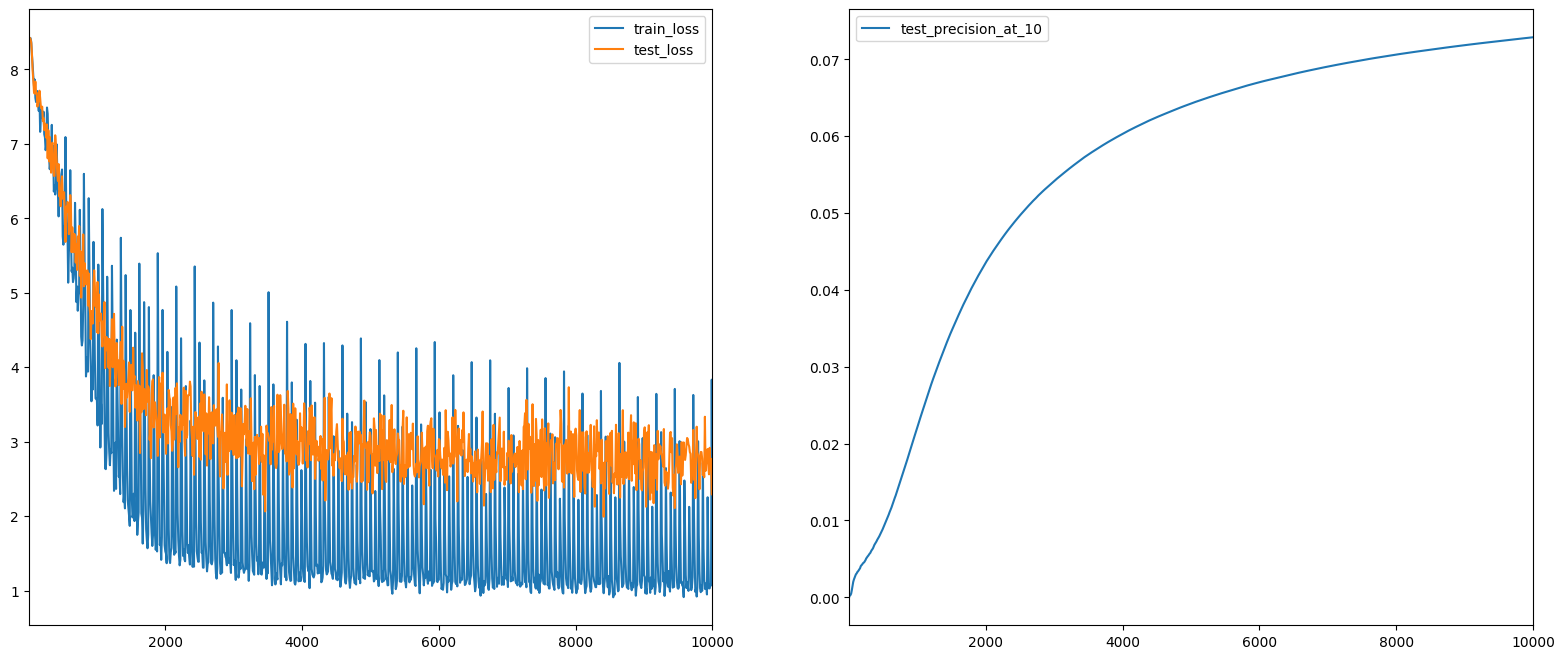

In [ ]:
softmax_model.train(
    learning_rate=3., num_iterations=10000, optimizer=tf.train.AdagradOptimizer)

# Making recommendations

In [ ]:
DOT = 'dot'
COSINE = 'cosine'
def compute_scores(query_embedding, item_embeddings, measure=DOT):
  """Computes the scores of the candidates given a query.
  Args:
    query_embedding: a vector of shape [k], representing the query embedding.
    item_embeddings: a matrix of shape [N, k], such that row i is the embedding
      of item i.
    measure: a string specifying the similarity measure to be used. Can be
      either DOT or COSINE.
  Returns:
    scores: a vector of shape [N], such that scores[i] is the score of item i.
  """
  u = query_embedding
  V = item_embeddings
  if measure == COSINE:
    V = V / np.linalg.norm(V, axis=1, keepdims=True)
    u = u / np.linalg.norm(u)
  scores = u.dot(V.T)
  return scores

In [ ]:
def game_neighbors(model, title_substring, measure=DOT, k=6):
  # Search for game ids that match the given substring.
  # ids =  games_df[games_df['name'].str.contains(title_substring)].index.values
  # Search for game ids with the exact name
  ids = games_df[games_df['name'] == title_substring].index.values
  titles = games_df.iloc[ids]['name'].values
  if len(titles) == 0:
    raise ValueError("Found no games with title %s" % title_substring)
  print("Nearest neighbors of : %s." % titles[0])
  if len(titles) > 1:
    print("[Found more than one matching game. Other candidates: {}]".format(
        ", ".join(titles[1:])))
  game_id = ids[0]
  scores = compute_scores(
      model.embeddings["app_id"][game_id], model.embeddings["app_id"],
      measure)
  score_key = measure + ' score'
  df = pd.DataFrame({
      score_key: list(scores),
      'titles': games_df['name'],
      'genres': games_df['genres'],
      'year': games_df['year'],
      'categories': games_df['categories'],
  })
  display.display(df.sort_values([score_key], ascending=False).head(k))

In [ ]:
# Extract all unique app_ids from the top_rows DataFrame
unique_app_ids = set([app_id for sublist in top_rows['app_id'].tolist() for app_id in sublist])

# Get the corresponding game names from the games_df DataFrame
unique_games_left = games_df[games_df['app_id'].isin(unique_app_ids)]['name']
print(len(unique_games_left))

# Search for a game in the cutdown dataframe
game_name = 'cyber'
unique_games_left[unique_games_left.str.contains(game_name, case=False)]

3660


1263        VA-11 Hall-A: Cyberpunk Bartender Action
1702     Cyberdimension Neptunia: 4 Goddesses Online
1711                                       Cyberhunt
1759                    FURIDASHI: Drift Cyber Sport
2112                                    Cyber Shadow
2392                       Cyber Knights: Flashpoint
2429    Digimon Story Cyber Sleuth: Complete Edition
2473                                    Cyber Driver
2542                                  Cyberpunk 2077
2624                                      Cyber Hook
2838                                   Cyber Manhunt
3136                             Bomb Rush Cyberfunk
Name: name, dtype: object

In [ ]:
game_neighbors(softmax_model, 'Half-Life', DOT)
game_neighbors(softmax_model, 'Half-Life', COSINE)

Nearest neighbors of : Half-Life.


,dot score,titles,genres,year,categories
4,38.092987,Half-Life,Action,1998,Single-player|Multi-player|PvP|Online PvP|Full...
17,19.851460,Portal 2,Action|Adventure,2011,Single-player|Multi-player|Co-op|Online Co-op|...
833,18.905533,"Guns, Gore & Cannoli",Action|Indie,2015,Single-player|Multi-player|PvP|Shared/Split Sc...
3165,18.884899,Crosshair X,Action|Adventure|Indie|Animation & Modeling|De...,2020,Captions available|Steam Workshop|Steam Cloud
11,18.834494,Portal,Action,2007,Single-player|Steam Achievements|Full controll...
2876,18.033583,Titanfall® 2,Action,2020,Single-player|Multi-player|PvP|Online PvP|Stea...


Nearest neighbors of : Half-Life.


,cosine score,titles,genres,year,categories
4,1.000000,Half-Life,Action,1998,Single-player|Multi-player|PvP|Online PvP|Full...
3165,0.563709,Crosshair X,Action|Adventure|Indie|Animation & Modeling|De...,2020,Captions available|Steam Workshop|Steam Cloud
583,0.557468,Bloody Trapland,Action|Adventure|Casual|Indie,2013,Single-player|Multi-player|PvP|Online PvP|Shar...
833,0.555452,"Guns, Gore & Cannoli",Action|Indie,2015,Single-player|Multi-player|PvP|Shared/Split Sc...
1,0.537647,Team Fortress Classic,Action,1999,Multi-player|PvP|Online PvP|Shared/Split Scree...
2,0.533846,Deathmatch Classic,Action,2001,Multi-player|PvP|Online PvP|Shared/Split Scree...


In [ ]:
game_neighbors(softmax_model, 'Counter-Strike', DOT)
game_neighbors(softmax_model, 'Counter-Strike', COSINE)

Nearest neighbors of : Counter-Strike.


,dot score,titles,genres,year,categories
0,35.153694,Counter-Strike,Action,2000,Multi-player|PvP|Online PvP|Shared/Split Scree...
831,21.211937,Geometry Dash,Action|Indie,2014,Single-player|Steam Achievements|Steam Trading...
705,19.158649,Metro 2033 Redux,Action,2014,Single-player|Steam Achievements|Full controll...
638,18.979025,Grand Theft Auto V,Action|Adventure,2015,Single-player|Multi-player|PvP|Online PvP|Co-o...
8,18.943844,Day of Defeat: Source,Action,2010,Multi-player|Cross-Platform Multiplayer|Steam ...
101,18.803432,BioShock Infinite,Action,2013,Single-player|Steam Achievements|Full controll...


Nearest neighbors of : Counter-Strike.


,cosine score,titles,genres,year,categories
0,1.000000,Counter-Strike,Action,2000,Multi-player|PvP|Online PvP|Shared/Split Scree...
8,0.622464,Day of Defeat: Source,Action,2010,Multi-player|Cross-Platform Multiplayer|Steam ...
831,0.588731,Geometry Dash,Action|Indie,2014,Single-player|Steam Achievements|Steam Trading...
4541,0.569750,Cozy Space,Casual|Simulation|Early Access,2023,Single-player
705,0.564523,Metro 2033 Redux,Action,2014,Single-player|Steam Achievements|Full controll...
430,0.545109,Tomb Raider IV: The Last Revelation,Action|Adventure,2012,Single-player


In [ ]:
game_neighbors(softmax_model, 'Cyberpunk 2077', DOT)
game_neighbors(softmax_model, 'Cyberpunk 2077', COSINE)

Nearest neighbors of : Cyberpunk 2077.


,dot score,titles,genres,year,categories
2542,39.130390,Cyberpunk 2077,RPG,2020,Single-player|Steam Achievements|Steam Trading...
2741,22.450012,Red Dead Redemption 2,Action|Adventure,2019,Single-player|Multi-player|PvP|Online PvP|Co-o...
1103,21.662725,Borderlands 3,Action|RPG,2020,Single-player|Multi-player|Co-op|Online Co-op|...
1576,19.689171,Assassin's Creed® Origins,Action|Adventure|RPG,2017,Single-player|Steam Achievements|Steam Trading...
119,19.460800,Grand Theft Auto IV: The Complete Edition,Action|Adventure,2020,Single-player|Multi-player|Partial Controller ...
1147,19.411863,Metro Exodus,Action,2020,Single-player|Steam Achievements|Full controll...


Nearest neighbors of : Cyberpunk 2077.


,cosine score,titles,genres,year,categories
2542,1.000000,Cyberpunk 2077,RPG,2020,Single-player|Steam Achievements|Steam Trading...
1103,0.629197,Borderlands 3,Action|RPG,2020,Single-player|Multi-player|Co-op|Online Co-op|...
2741,0.576877,Red Dead Redemption 2,Action|Adventure,2019,Single-player|Multi-player|PvP|Online PvP|Co-o...
1576,0.572738,Assassin's Creed® Origins,Action|Adventure|RPG,2017,Single-player|Steam Achievements|Steam Trading...
119,0.543829,Grand Theft Auto IV: The Complete Edition,Action|Adventure,2020,Single-player|Multi-player|Partial Controller ...
1147,0.524029,Metro Exodus,Action,2020,Single-player|Steam Achievements|Full controll...


In [ ]:
game_neighbors(softmax_model, 'Grand Theft Auto V', DOT)
game_neighbors(softmax_model, 'Grand Theft Auto V', COSINE)

Nearest neighbors of : Grand Theft Auto V.


,dot score,titles,genres,year,categories
638,40.800396,Grand Theft Auto V,Action|Adventure,2015,Single-player|Multi-player|PvP|Online PvP|Co-o...
17,22.852242,Portal 2,Action|Adventure,2011,Single-player|Multi-player|Co-op|Online Co-op|...
4199,22.273405,Resident Evil 4,Action|Adventure,2023,Single-player|Steam Achievements|Full controll...
319,21.243147,Terraria,Action|Adventure|Indie|RPG,2011,Single-player|Multi-player|PvP|Online PvP|Co-o...
2741,21.163843,Red Dead Redemption 2,Action|Adventure,2019,Single-player|Multi-player|PvP|Online PvP|Co-o...
1981,20.525219,DOOM Eternal,Action,2020,Single-player|Multi-player|PvP|Online PvP|Stea...


Nearest neighbors of : Grand Theft Auto V.


,cosine score,titles,genres,year,categories
638,1.000000,Grand Theft Auto V,Action|Adventure,2015,Single-player|Multi-player|PvP|Online PvP|Co-o...
2287,0.609046,Walking Zombie 2,Action|Adventure|Indie|RPG,2019,Single-player|Steam Achievements|Steam Trading...
2003,0.603504,MXGP PRO,Racing|Simulation|Sports,2018,Single-player|Multi-player|PvP|Online PvP|Stea...
17,0.573074,Portal 2,Action|Adventure,2011,Single-player|Multi-player|Co-op|Online Co-op|...
1981,0.561211,DOOM Eternal,Action,2020,Single-player|Multi-player|PvP|Online PvP|Stea...
4199,0.545687,Resident Evil 4,Action|Adventure,2023,Single-player|Steam Achievements|Full controll...


In [ ]:
def user_recommendations(model, id, measure=DOT, exclude_rated=False, k=6):
  """
  Recommend items similar to the user's list of reviewed games
  """
  app_ids = top_rows[top_rows['steam_id'] == id]['app_id'].values[0]
  played_games = games_df[games_df['app_id'].isin(app_ids)]
  print(f"Games that user {id} has reviewed:")
  display.display(played_games[['app_id', 'name', 'categories', 'genres', 'year']])

  final_scores = np.zeros(len(model.embeddings['app_id']))

  for app_id in app_ids:
    scores = compute_scores(model.embeddings['app_id'][int(app_id)], softmax_model.embeddings['app_id'], measure)
    final_scores += scores

  average_scores = final_scores / len(app_ids)

  score_key = 'average' + measure + ' score'
  df = pd.DataFrame({
      score_key: list(average_scores),
      'app_id': games_df['app_id'],
      'name': games_df['name'],
      'categories': games_df['categories'],
      'genres': games_df['genres'],
      'year': games_df['year'],
  })

  if exclude_rated:
      rated_games = top_rows[top_rows.steam_id == id]['app_id'].values[0]
      df = df[df.app_id.apply(lambda app_id: app_id not in rated_games)]
  print("Recommendations:")
  display.display(df.sort_values([score_key], ascending=False).head(k))

In [ ]:
user_recommendations(softmax_model, '20263', DOT, exclude_rated=True)

Games that user 20263 has reviewed:


,app_id,name,categories,genres,year
3059,3059,Cult of the Lamb,Single-player|Steam Achievements|Full controll...,Action|Adventure|Indie|Strategy,2022
3104,3104,The Cosmic Wheel Sisterhood,Single-player|Steam Achievements|Full controll...,Adventure|Indie,2023
3154,3154,The Room 4: Old Sins,Single-player|Steam Achievements|Steam Trading...,Adventure,2021
3307,3307,Sun Haven,Single-player|Multi-player|Co-op|Online Co-op|...,Adventure|Casual|Indie|RPG|Simulation,2023


Recommendations:


,averagedot score,app_id,name,categories,genres,year
4412,13.911755,4412,Underground Blossom,Single-player|Steam Achievements|Steam Cloud,Adventure|Indie,2023
3077,12.298086,3077,Lost in Play,Single-player|Steam Achievements|Full controll...,Adventure|Indie,2022
3991,12.154339,3991,DAVE THE DIVER,Single-player|Steam Achievements|Full controll...,Adventure|Casual|Indie|RPG|Simulation,2023
3456,12.104975,3456,The Past Within,Multi-player|Co-op|Online Co-op|Cross-Platform...,Adventure|Indie,2022
3660,11.986393,3660,A Little to the Left,Single-player|Steam Achievements|Full controll...,Casual|Indie,2022
2821,11.836270,2821,Potion Craft: Alchemist Simulator,Single-player|Steam Achievements|Partial Contr...,Indie|Simulation,2022


In [ ]:
user_recommendations(softmax_model, '20263', COSINE, exclude_rated=True)

Games that user 20263 has reviewed:


,app_id,name,categories,genres,year
3059,3059,Cult of the Lamb,Single-player|Steam Achievements|Full controll...,Action|Adventure|Indie|Strategy,2022
3104,3104,The Cosmic Wheel Sisterhood,Single-player|Steam Achievements|Full controll...,Adventure|Indie,2023
3154,3154,The Room 4: Old Sins,Single-player|Steam Achievements|Steam Trading...,Adventure,2021
3307,3307,Sun Haven,Single-player|Multi-player|Co-op|Online Co-op|...,Adventure|Casual|Indie|RPG|Simulation,2023


Recommendations:


,averagecosine score,app_id,name,categories,genres,year
4412,0.416896,4412,Underground Blossom,Single-player|Steam Achievements|Steam Cloud,Adventure|Indie,2023
3077,0.390335,3077,Lost in Play,Single-player|Steam Achievements|Full controll...,Adventure|Indie,2022
3695,0.387403,3695,Moonstone Island,Single-player|Steam Achievements|Full controll...,Adventure|Indie|RPG,2023
3660,0.386407,3660,A Little to the Left,Single-player|Steam Achievements|Full controll...,Casual|Indie,2022
4069,0.373850,4069,Spirittea,Single-player|Steam Achievements|Full controll...,Adventure|RPG|Simulation,2023
3991,0.370089,3991,DAVE THE DIVER,Single-player|Steam Achievements|Full controll...,Adventure|Casual|Indie|RPG|Simulation,2023


In [ ]:
def recommend_based_on_vote(model, id, measure=DOT, exclude_rated=False, k=6):
  """
  Only recommend items similar to the user's voted up games (voted_up = 1)
  """
  app_ids = list(user_game_df[(user_game_df['steam_id'] == id) & (user_game_df['voted_up'])]['app_id'])
  played_games = games_df[games_df['app_id'].isin(app_ids)]
  print(f"Games that user {id} has reviewed and voted up:")
  display.display(played_games[['app_id', 'name', 'categories', 'genres', 'year']])

  final_scores = np.zeros(len(model.embeddings['app_id']))

  for app_id in app_ids:
    scores = compute_scores(model.embeddings['app_id'][int(app_id)], softmax_model.embeddings['app_id'], measure)
    final_scores += scores

  average_scores = final_scores / len(unique_app_ids)

  score_key = 'average' + measure + ' score'
  df = pd.DataFrame({
      score_key: list(average_scores),
      'app_id': games_df['app_id'],
      'name': games_df['name'],
      'categories': games_df['categories'],
      'genres': games_df['genres'],
      'year': games_df['year'],
  })

  if exclude_rated:
      rated_games = top_rows[top_rows.steam_id == id]['app_id'].values[0]
      df = df[df.app_id.apply(lambda app_id: app_id not in rated_games)]
  print("Recommendations:")
  display.display(df.sort_values([score_key], ascending=False).head(k))

In [ ]:
def recommend_based_on_playtime(model, id, measure=DOT, exclude_rated=False, k=6):
  """
  Only recommend items similar to the games where the user's playtime is above average
  """
  average_playtime = np.array(user_game_df[user_game_df['steam_id'] == id]['playtime_forever']).mean()
  app_ids = list(user_game_df[(user_game_df['steam_id'] == id) & (user_game_df['playtime_forever'] > average_playtime)]['app_id'])
  played_games = games_df[games_df['app_id'].isin(app_ids)]
  print(f"Games that user {id} has played for an above-average amount of time:")
  display.display(played_games[['app_id', 'name', 'categories', 'genres', 'year']])

  final_scores = np.zeros(len(model.embeddings['app_id']))

  for app_id in app_ids:
    scores = compute_scores(model.embeddings['app_id'][int(app_id)], softmax_model.embeddings['app_id'], measure)
    final_scores += scores

  average_scores = final_scores / len(app_ids)

  score_key = 'average' + measure + ' score'
  df = pd.DataFrame({
      score_key: list(average_scores),
      'app_id': games_df['app_id'],
      'name': games_df['name'],
      'categories': games_df['categories'],
      'genres': games_df['genres'],
      'year': games_df['year'],
  })

  if exclude_rated:
      rated_games = top_rows[top_rows.steam_id == id]['app_id'].values[0]
      df = df[df.app_id.apply(lambda app_id: app_id not in rated_games)]
  print("Recommendations:")
  display.display(df.sort_values([score_key], ascending=False).head(k))

In [ ]:
recommend_based_on_vote(softmax_model, '20263', COSINE)

Games that user 20263 has reviewed and voted up:


,app_id,name,categories,genres,year
3059,3059,Cult of the Lamb,Single-player|Steam Achievements|Full controll...,Action|Adventure|Indie|Strategy,2022
3104,3104,The Cosmic Wheel Sisterhood,Single-player|Steam Achievements|Full controll...,Adventure|Indie,2023
3154,3154,The Room 4: Old Sins,Single-player|Steam Achievements|Steam Trading...,Adventure,2021
3307,3307,Sun Haven,Single-player|Multi-player|Co-op|Online Co-op|...,Adventure|Casual|Indie|RPG|Simulation,2023


Recommendations:


,averagecosine score,app_id,name,categories,genres,year
3307,0.000555,3307,Sun Haven,Single-player|Multi-player|Co-op|Online Co-op|...,Adventure|Casual|Indie|RPG|Simulation,2023
3104,0.000540,3104,The Cosmic Wheel Sisterhood,Single-player|Steam Achievements|Full controll...,Adventure|Indie,2023
3059,0.000518,3059,Cult of the Lamb,Single-player|Steam Achievements|Full controll...,Action|Adventure|Indie|Strategy,2022
3154,0.000478,3154,The Room 4: Old Sins,Single-player|Steam Achievements|Steam Trading...,Adventure,2021
4412,0.000456,4412,Underground Blossom,Single-player|Steam Achievements|Steam Cloud,Adventure|Indie,2023
3077,0.000427,3077,Lost in Play,Single-player|Steam Achievements|Full controll...,Adventure|Indie,2022


In [ ]:
recommend_based_on_playtime(softmax_model, '20263')

Games that user 20263 has played for an above-average amount of time:


,app_id,name,categories,genres,year
3307,3307,Sun Haven,Single-player|Multi-player|Co-op|Online Co-op|...,Adventure|Casual|Indie|RPG|Simulation,2023


Recommendations:


,averagedot score,app_id,name,categories,genres,year
3307,32.230347,3307,Sun Haven,Single-player|Multi-player|Co-op|Online Co-op|...,Adventure|Casual|Indie|RPG|Simulation,2023
2821,18.495682,2821,Potion Craft: Alchemist Simulator,Single-player|Steam Achievements|Partial Contr...,Indie|Simulation,2022
4101,17.520092,4101,Hero's Adventure: Road to Passion,Single-player|Steam Achievements|Full controll...,Adventure|Indie|RPG|Simulation,2023
4069,16.931187,4069,Spirittea,Single-player|Steam Achievements|Full controll...,Adventure|RPG|Simulation,2023
3475,16.458551,3475,Wartales,Single-player|Multi-player|Co-op|Online Co-op|...,Adventure|Indie|RPG|Strategy,2023
4065,16.314440,4065,Monument Valley: Panoramic Edition,Single-player|Steam Achievements|Steam Cloud,Adventure|Casual|Indie|Strategy,2022
